#  Descriptive Trend & Time-Series Analysis for a Food Delivery Platform
**Portfolio Case Study**

This project explores **what happened over time** in a multi-restaurant delivery business, using a real-world Kaggle dataset of 21k+ orders.  
Our goal is to uncover **trends, seasonality, and structural shifts** that impact operations — enabling smarter staffing, staging, and service-level protection.

###  Why This Analysis Matters
- **Anticipate Demand Peaks** — Align rider shifts and kitchen staging with true order patterns (day/hour, holiday).
- **Detect Service Slowdowns** — Spot when delivery times and cancellations creep up before SLA targets slip.
- **Inform Actionable Playbooks** — Support decisions like capacity holds, targeted promos, and SLA buffers.

##  Dataset Introduction

This analysis uses the **[Food Delivery Order History Data](https://www.kaggle.com/datasets/sujalsuthar/food-delivery-order-history-data/data)** hosted on Kaggle.

**Dataset Overview:**
- **21,321 orders** from **6 restaurants** across multiple subzones and cities.
- Captures **restaurant details**, **order timestamps**, **delivery times**, **distance**,  
- Well-suited for exploring **demand patterns**, **seasonality**, and **operational bottlenecks**.


## Business Problem Framing

**Context:**  
You operate a food delivery marketplace spanning multiple restaurants and zones.  
Leadership wants to answer:

- **When** do orders spike and are we properly staffed during these peaks?  
- **Are delivery times drifting up** during high-volume periods, risking SLA breaches?  
- **Which restaurants/zones drive most of the demand** — and should get priority for capacity planning?

**Analytical Goal:**  
First, **quantify what happened**: orders, revenue, and operational metrics across time (daily/weekly/monthly).  
Then, uncover **patterns and seasonality** to support better staffing, staging, and performance management.


In [18]:
# --- Environment Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys, os, warnings
warnings.filterwarnings("ignore")

# Wider table view (optional)
pd.set_option("display.max_columns", 80)

# Consistent, professional plotting style
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.titlesize": 13,
    "axes.labelsize": 11
})

In [19]:
# --- Load Attached CSV ---
df = pd.read_csv('/content/order_history_kaggle_data.csv')

print(f"Dataframe Shape: {len(df):,} rows × {len(df.columns)} columns")
display(df.head(2))  # quick peek at first 2 rows

print("\nInfo:")
print(df.info())



Dataframe Shape: 21,321 rows × 29 columns


,Restaurant ID,Restaurant name,Subzone,City,Order ID,Order Placed At,Order Status,Delivery,Distance,Items in order,Instructions,Discount construct,Bill subtotal,Packaging charges,Restaurant discount (Promo),"Restaurant discount (Flat offs, Freebies & others)",Gold discount,Brand pack discount,Total,Rating,Review,Cancellation / Rejection reason,Restaurant compensation (Cancellation),Restaurant penalty (Rejection),KPT duration (minutes),Rider wait time (minutes),Order Ready Marked,Customer complaint tag,Customer ID
0,20320607,Swaad,Sector 4,Delhi NCR,6168884918,"11:38 PM, September 10 2024",Delivered,Zomato Delivery,3km,"1 x Grilled Chicken Jamaican Tender, 1 x Grill...",NaN,40% off upto Rs.80,715.0,31.75,80.0,0.0,0.0,0.0,666.75,NaN,NaN,NaN,NaN,NaN,18.35,11.6,Correctly,NaN,5d6c2b96db963098bc69768bea504c8bf46106a8a5178e...
1,20320607,Swaad,Sector 4,Delhi NCR,6170707559,"11:34 PM, September 10 2024",Delivered,Zomato Delivery,2km,"1 x Peri Peri Fries, 1 x Fried Chicken Angara ...",NaN,Flat Rs.175 off,1179.0,50.20,175.0,0.0,0.0,0.0,1054.20,NaN,NaN,NaN,NaN,NaN,16.95,3.6,Correctly,NaN,0781815deb4a10a574e9fee4fa0b86b074d4a0b36175d5...



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21321 entries, 0 to 21320
Data columns (total 29 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Restaurant ID                                       21321 non-null  int64  
 1   Restaurant name                                     21321 non-null  object 
 2   Subzone                                             21321 non-null  object 
 3   City                                                21321 non-null  object 
 4   Order ID                                            21321 non-null  int64  
 5   Order Placed At                                     21321 non-null  object 
 6   Order Status                                        21321 non-null  object 
 7   Delivery                                            21321 non-null  object 
 8   Distance                                            21321 non-null  o

##  Analytical Plan — Columns & Questions

Before diving into code, we define **what to extract from the dataset and why** — aligning analysis steps with the business questions.

### 1. Data Quality & Audit  
- **Steps:** Missing-value analysis, column type checks, outlier detection  
- **Purpose:** Ensure the dataset is reliable before deeper analysis

### 2. Time Columns  
- **Source:** `Order Placed At` → convert to datetime  
- **Derived:** Day-of-week, hour-of-day, month, year  
- **Purpose:** Identify demand peaks and seasonality

### 3. Operational Metrics  
- **Columns:** `KPT duration`, `Rider wait time`, `Distance`, `Order Status`  
- **Purpose:** Track prep & delivery performance; spot slowdowns during peaks

### 4. Revenue Metrics  
- **Columns:** `Total`, `Bill subtotal`, discount fields  
- **Purpose:** Quantify monetary impact of demand patterns and discounts

### 5. Restaurant & Zone Dimensions  
- **Columns:** `Restaurant name`, `Subzone`, `City`  
- **Purpose:** Find top contributors to demand and operational load


## EDA — Step 1: Data Quality & Parsing

Before any trend analysis, we must confirm that the dataset is clean and reliable.

**Key checks in this step:**
1. **Missing Values** — identify columns with high NaN counts.
2. **Column Types** — verify numeric columns and key timestamps are properly typed.
3. **Sanity Checks** — look for extreme values (prep time, wait time, revenue) that could skew results.

This ensures subsequent insights are based on trustworthy data.


In [20]:
# --- Step 1: Data Quality Audit ---

# 1) Missing values summary (sorted, to see worst offenders first)
missing_summary = (
    df.isna()
      .sum()
      .sort_values(ascending=False)
      .to_frame(name="Missing Count")
)
missing_summary["Missing %"] = (missing_summary["Missing Count"] / len(df)) * 100
display(missing_summary.style.format({"Missing %": "{:.2f}%"}))

# 2) Column data types
print("\nColumn Data Types:")
print(df.dtypes)

# 3) Descriptive statistics for numeric columns (sanity check)
print("\nNumeric Columns Summary:")
display(df.describe().T)

# 4) Preview a few key columns to eyeball formatting
df[['Order Placed At','Distance','KPT duration (minutes)',
    'Rider wait time (minutes)','Total','Order Status']].head()


,Missing Count,Missing %
Restaurant penalty (Rejection),21318,99.99%
Restaurant compensation (Cancellation),21188,99.38%
Cancellation / Rejection reason,21135,99.13%
Review,21025,98.61%
Customer complaint tag,20852,97.80%
Instructions,20601,96.62%
Rating,18830,88.32%
Discount construct,5498,25.79%
KPT duration (minutes),295,1.38%
Rider wait time (minutes),168,0.79%



Column Data Types:
Restaurant ID                                           int64
Restaurant name                                        object
Subzone                                                object
City                                                   object
Order ID                                                int64
Order Placed At                                        object
Order Status                                           object
Delivery                                               object
Distance                                               object
Items in order                                         object
Instructions                                           object
Discount construct                                     object
Bill subtotal                                         float64
Packaging charges                                     float64
Restaurant discount (Promo)                           float64
Restaurant discount (Flat offs, Freebies & others)

,count,mean,std,min,25%,50%,75%,max
Restaurant ID,21321.0,2.074413e+07,2.447193e+05,2.032061e+07,2.063570e+07,2.065987e+07,2.088265e+07,2.152306e+07
Order ID,21321.0,6.354622e+09,1.230263e+08,6.086767e+09,6.250751e+09,6.357715e+09,6.456827e+09,6.573392e+09
Bill subtotal,21321.0,7.500768e+02,4.987594e+02,5.000000e+01,4.590000e+02,6.290000e+02,8.990000e+02,1.608000e+04
Packaging charges,21321.0,3.256459e+01,2.223590e+01,0.000000e+00,1.845000e+01,2.845000e+01,3.995000e+01,6.030000e+02
Restaurant discount (Promo),21321.0,6.509182e+01,8.540160e+01,0.000000e+00,0.000000e+00,8.000000e+01,1.000000e+02,4.020000e+03
"Restaurant discount (Flat offs, Freebies & others)",21321.0,3.179506e+01,1.314871e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.787000e+03
Gold discount,21321.0,9.912762e-02,3.264261e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.801000e+02
Brand pack discount,21321.0,3.039324e+00,1.707078e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.548000e+02
Total,21321.0,6.826161e+02,4.653140e+02,5.250000e+01,3.874500e+02,5.974500e+02,8.379000e+02,1.266300e+04
Rating,2491.0,4.356885e+00,1.181472e+00,1.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


,Order Placed At,Distance,KPT duration (minutes),Rider wait time (minutes),Total,Order Status
0,"11:38 PM, September 10 2024",3km,18.35,11.6,666.75,Delivered
1,"11:34 PM, September 10 2024",2km,16.95,3.6,1054.20,Delivered
2,"03:52 PM, September 10 2024",<1km,14.05,12.2,241.50,Delivered
3,"03:45 PM, September 10 2024",2km,19.00,3.3,567.00,Delivered
4,"03:04 PM, September 10 2024",2km,15.97,1.0,529.20,Delivered


##  EDA — Step 2: Outlier Exploration

Before cleaning or clipping, we visualize key numeric metrics to understand their distributions and spot potential outliers.

**Columns to inspect:**
- `KPT duration (minutes)` — kitchen prep times
- `Rider wait time (minutes)` — courier wait times
- `Bill subtotal` & `Total` — order value distributions

We use boxplots and histograms to reveal extreme values that might skew averages or trends.


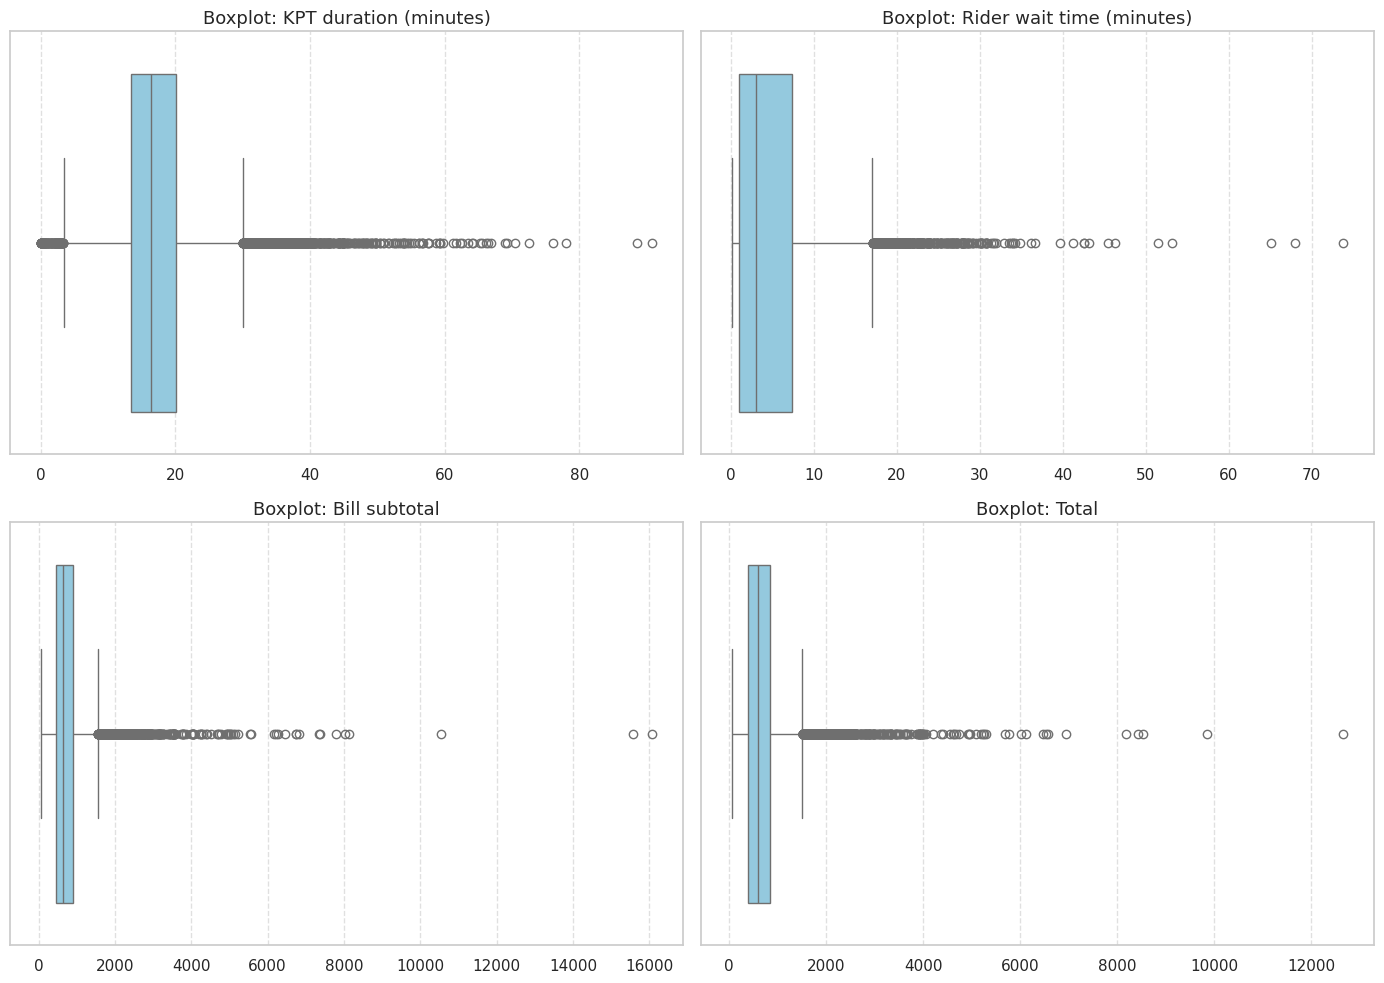

In [21]:
# --- Outlier detection with Seaborn boxplots (full range) ---
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['KPT duration (minutes)', 'Rider wait time (minutes)', 'Bill subtotal', 'Total']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i], color="skyblue")
    axes[i].set_title(f"Boxplot: {col}")
    axes[i].set_xlabel("")
    axes[i].grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


# --- Interactive histograms with Plotly (full range) ---
import plotly.graph_objects as go
import plotly.subplots as sp

fig_hist = sp.make_subplots(
    rows=1, cols=2,
    subplot_titles=["KPT Duration Distribution (Full Range)", "Rider Wait Time Distribution (Full Range)"]
)

fig_hist.add_trace(
    go.Histogram(
        x=df['KPT duration (minutes)'],
        nbinsx=50,
        name="KPT duration (min)"
    ),
    row=1, col=1
)

fig_hist.add_trace(
    go.Histogram(
        x=df['Rider wait time (minutes)'],
        nbinsx=50,
        name="Rider wait (min)"
    ),
    row=1, col=2
)

fig_hist.update_layout(
    height=420, width=1000,
    title_text="Distribution of Key Operational Metrics (Interactive)",
    bargap=0.08,
    hovermode="x"
)

fig_hist.update_xaxes(title_text="Minutes", row=1, col=1)
fig_hist.update_xaxes(title_text="Minutes", row=1, col=2)
fig_hist.update_yaxes(title_text="Count", row=1, col=1)
fig_hist.update_yaxes(title_text="Count", row=1, col=2)

fig_hist.show()


###  Outlier Treatment Decision

**Key Finding:**  
Outliers in this dataset are rare but carry business meaning:

- **KPT duration:** A small number of very long prep times (beyond boxplot whiskers) likely reflect large or complex orders — not errors.
- **Rider wait time:** Boxplot analysis flags outliers starting roughly beyond the upper whisker (~17+ minutes). These represent extreme delays and are important signals of capacity stress.
- **Revenue metrics:** Boxplot shows a few very high-value orders. These are legitimate bulk or catering orders and should remain in the analysis.

**Decision:**  
**We retain all rows — no outliers are removed.**

**Rationale:**
- These extreme cases represent real operational challenges and revenue opportunities.
- Removing them would hide insights that managers need to address (e.g., capacity stress during peaks).



In [22]:
# --- Parsing & Cleaning for Time-Series Analysis ---

# 1) Parse Order Placed At into datetime
df['Order Placed At'] = pd.to_datetime(
    df['Order Placed At'],
    format='%I:%M %p, %B %d %Y',
    errors='coerce'
)

# 2) Derive time-based features
df['date'] = df['Order Placed At'].dt.date
df['day_of_week'] = df['Order Placed At'].dt.day_name()
df['hour'] = df['Order Placed At'].dt.hour
df['month'] = df['Order Placed At'].dt.month
df['year'] = df['Order Placed At'].dt.year

# 3) Clean Distance: handle "<1km" as 0.5, strip 'km', convert to float
df['Distance'] = (
    df['Distance']
    .str.replace('<1km', '0.5', regex=False)
    .str.replace('km', '', regex=False)
    .astype(float)
)

# Display a quick preview to confirm transformations
display(df[['Order Placed At', 'date', 'day_of_week', 'hour', 'month', 'year', 'Distance']].head())


,Order Placed At,date,day_of_week,hour,month,year,Distance
0,2024-09-10 23:38:00,2024-09-10,Tuesday,23,9,2024,3.0
1,2024-09-10 23:34:00,2024-09-10,Tuesday,23,9,2024,2.0
2,2024-09-10 15:52:00,2024-09-10,Tuesday,15,9,2024,0.5
3,2024-09-10 15:45:00,2024-09-10,Tuesday,15,9,2024,2.0
4,2024-09-10 15:04:00,2024-09-10,Tuesday,15,9,2024,2.0


##  EDA — Step 3: Trend Exploration

With cleaned time columns, we now explore **when** demand occurs:

- **Daily trend:** Total orders and revenue over time — check seasonality, dips, growth.
- **Day-of-week pattern:** Identify weekdays vs. weekend peaks.
- **Hour-of-day pattern:** Find lunch/dinner rush periods for staffing and promotions.

This step answers management's first question:  
> “When do orders spike and where might we be under-staffed?”


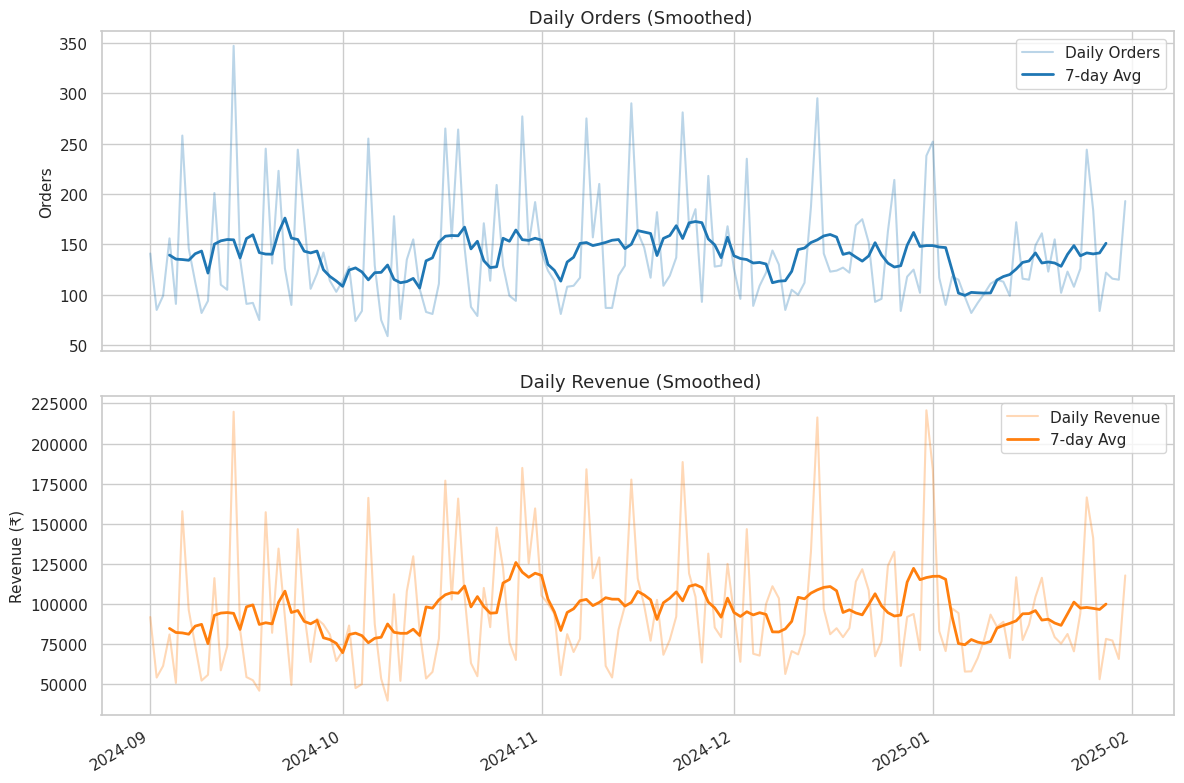

In [23]:
import matplotlib.pyplot as plt

# Group by date
daily_trend = df.groupby('date').agg(
    orders=('Order ID', 'count'),
    revenue=('Total', 'sum')
).reset_index()

# Create 7-day rolling averages
daily_trend['orders_7d'] = daily_trend['orders'].rolling(window=7, center=True).mean()
daily_trend['revenue_7d'] = daily_trend['revenue'].rolling(window=7, center=True).mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Orders
ax1.plot(daily_trend['date'], daily_trend['orders'], alpha=0.3, color='tab:blue', label='Daily Orders')
ax1.plot(daily_trend['date'], daily_trend['orders_7d'], color='tab:blue', linewidth=2, label='7-day Avg')
ax1.set_ylabel("Orders")
ax1.set_title(" Daily Orders (Smoothed)")
ax1.legend()

# Revenue
ax2.plot(daily_trend['date'], daily_trend['revenue'], alpha=0.3, color='tab:orange', label='Daily Revenue')
ax2.plot(daily_trend['date'], daily_trend['revenue_7d'], color='tab:orange', linewidth=2, label='7-day Avg')
ax2.set_ylabel("Revenue (₹)")
ax2.set_title(" Daily Revenue (Smoothed)")
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


###  Daily Trend Insights

**Observations:**

- **Noise reduction:** The 7-day rolling average smooths daily fluctuations and reveals the true demand pattern.
- **Stable base demand:** Orders and revenue show a consistent mid-range baseline.
- **Peaks:** Several pronounced spikes are visible, likely corresponding to weekends or special events.
- **No major drops:** There are no sustained periods of zero demand, suggesting healthy business continuity.

**Business Implication:**

- The business can use these peaks to schedule additional riders and kitchen staff during high-volume days.
- Stable baseline demand implies predictable inventory needs, allowing better vendor planning.


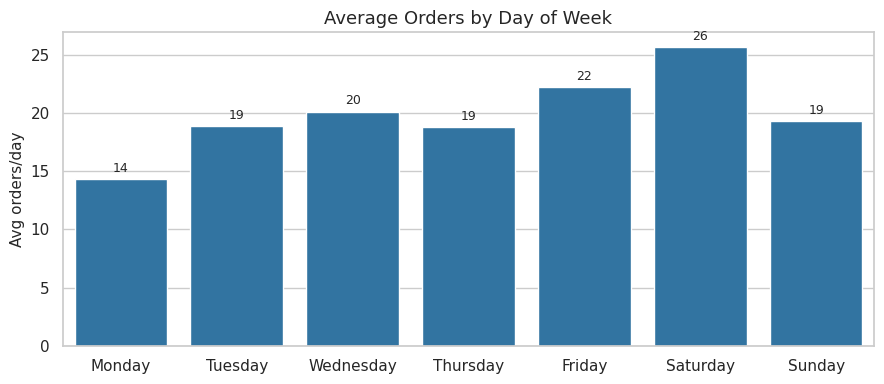

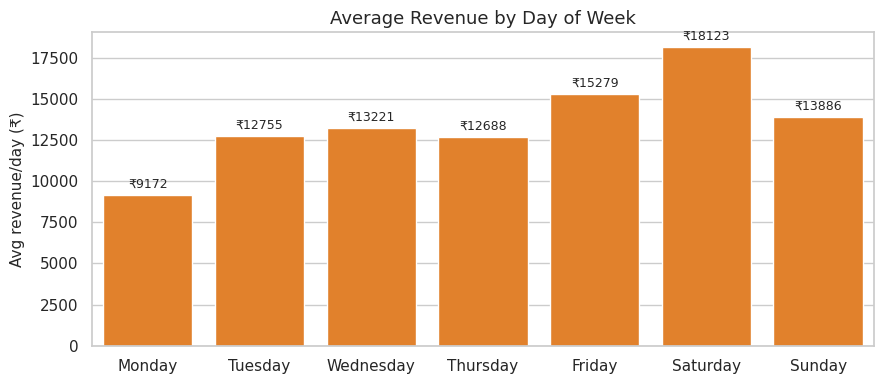

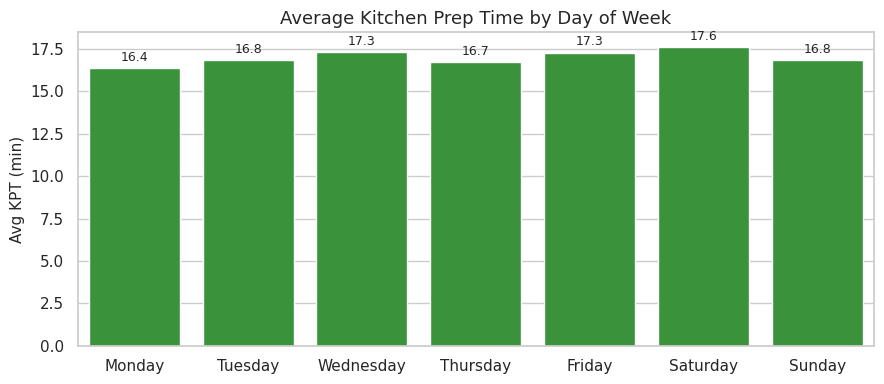

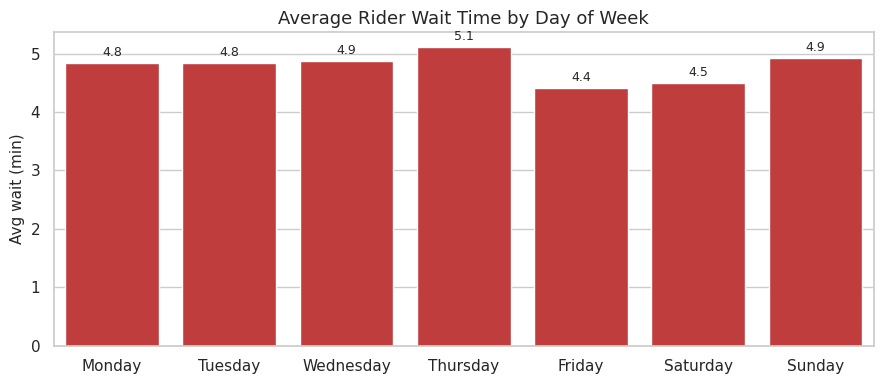

,day_of_week,avg_orders,avg_revenue,avg_kpt,avg_wait
0,Monday,14.4,₹9172,16.36,4.84
1,Tuesday,18.9,₹12755,16.82,4.83
2,Wednesday,20.1,₹13221,17.31,4.88
3,Thursday,18.8,₹12688,16.71,5.11
4,Friday,22.2,₹15279,17.28,4.41
5,Saturday,25.6,₹18123,17.59,4.50
6,Sunday,19.3,₹13886,16.85,4.93


In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Ensure Mon→Sun ordering ---
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=dow_order, ordered=True)

# --- Per-day stats to avoid bias ---
daily_by_dow = (
    df.groupby(['date','day_of_week'])
      .agg(orders=('Order ID','count'),
           revenue=('Total','sum'),
           avg_kpt=('KPT duration (minutes)','mean'),
           avg_wait=('Rider wait time (minutes)','mean'))
      .reset_index()
)

dow_summary = (
    daily_by_dow.groupby('day_of_week', observed=True)
                .agg(avg_orders=('orders','mean'),
                     avg_revenue=('revenue','mean'),
                     avg_kpt=('avg_kpt','mean'),
                     avg_wait=('avg_wait','mean'))
                .reset_index()
)

# --- Helper to make labeled barplots ---
def labeled_barplot(ax, data, x, y, color, title, ylabel, fmt):
    sns.barplot(data=data, x=x, y=y, ax=ax, color=color)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('')
    for c in ax.containers:
        ax.bar_label(c, fmt=fmt, fontsize=9, padding=3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# --- PLOT 1: Orders ---
fig, ax1 = plt.subplots(figsize=(9, 4))
labeled_barplot(ax1, dow_summary, 'day_of_week', 'avg_orders',
                color='tab:blue',
                title='Average Orders by Day of Week',
                ylabel='Avg orders/day',
                fmt="%.0f")
plt.tight_layout(); plt.show()

# --- PLOT 2: Revenue ---
fig, ax2 = plt.subplots(figsize=(9, 4))
labeled_barplot(ax2, dow_summary, 'day_of_week', 'avg_revenue',
                color='tab:orange',
                title='Average Revenue by Day of Week',
                ylabel='Avg revenue/day (₹)',
                fmt="₹%.0f")
plt.tight_layout(); plt.show()

# --- PLOT 3: Kitchen Prep Time ---
fig, ax3 = plt.subplots(figsize=(9, 4))
labeled_barplot(ax3, dow_summary, 'day_of_week', 'avg_kpt',
                color='tab:green',
                title='Average Kitchen Prep Time by Day of Week',
                ylabel='Avg KPT (min)',
                fmt="%.1f")
plt.tight_layout(); plt.show()

# --- PLOT 4: Rider Wait Time ---
fig, ax4 = plt.subplots(figsize=(9, 4))
labeled_barplot(ax4, dow_summary, 'day_of_week', 'avg_wait',
                color='tab:red',
                title='Average Rider Wait Time by Day of Week',
                ylabel='Avg wait (min)',
                fmt="%.1f")
plt.tight_layout(); plt.show()

# --- Summary Table ---
display(
    dow_summary.style.format({
        "avg_orders": "{:.1f}",
        "avg_revenue": "₹{:.0f}",
        "avg_kpt": "{:.2f}",
        "avg_wait": "{:.2f}"
    }).set_caption("Average Metrics by Day of Week")
)


##  Day-of-Week Performance — Insights

**Orders & Revenue**
- **Saturday** clearly leads on both orders and revenue; **Monday** is the softest.
- Friday and Sunday are also above mid-week, confirming a weekend-skewed demand pattern.

**Kitchen Prep Time (KPT)**
- Stable across the week at ~**16–18 min**.
- Small uptick on **Saturday** (≈17.6 min) but still well within a healthy range.

**Rider Wait Time**
- Generally **4–5 min**.
- **Friday–Saturday** are **slightly lower** than average (good dispatch efficiency even under higher volume).
- **Thursday** shows a modest elevation (≈5.1 min).

### What we’ll do (business lens)
- **Capacity & Staffing:** Current setup appears **well-tuned** for high-volume days; **no additional staffing** recommended at this time. Continue monitoring as volume scales.
- **Promo Strategy:** Use **Monday** incentives to lift base demand; consider light **mid-week bundles** to smooth revenue.
- **Ops Focus:** Keep an eye on **Thursday** rider waits and **Saturday** KPT for early signs of strain, but no intervention needed now.


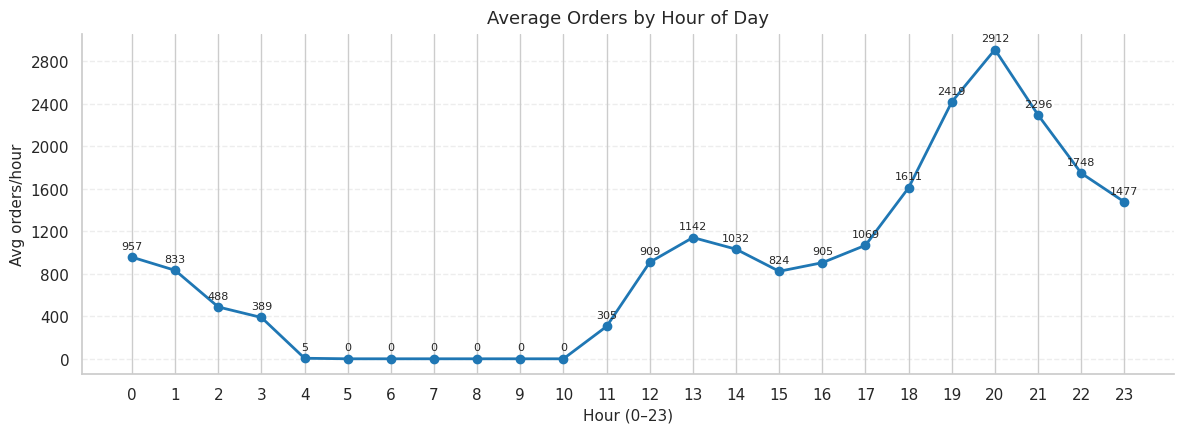

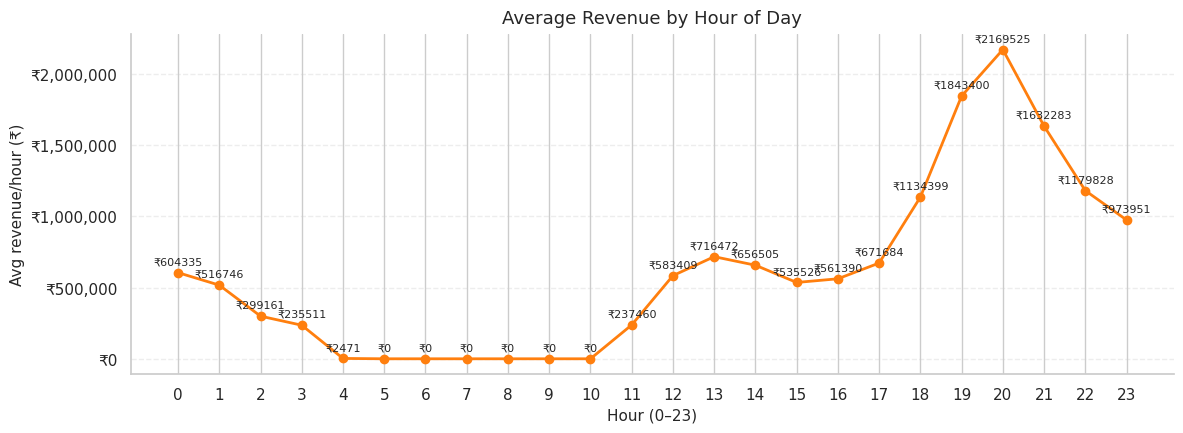

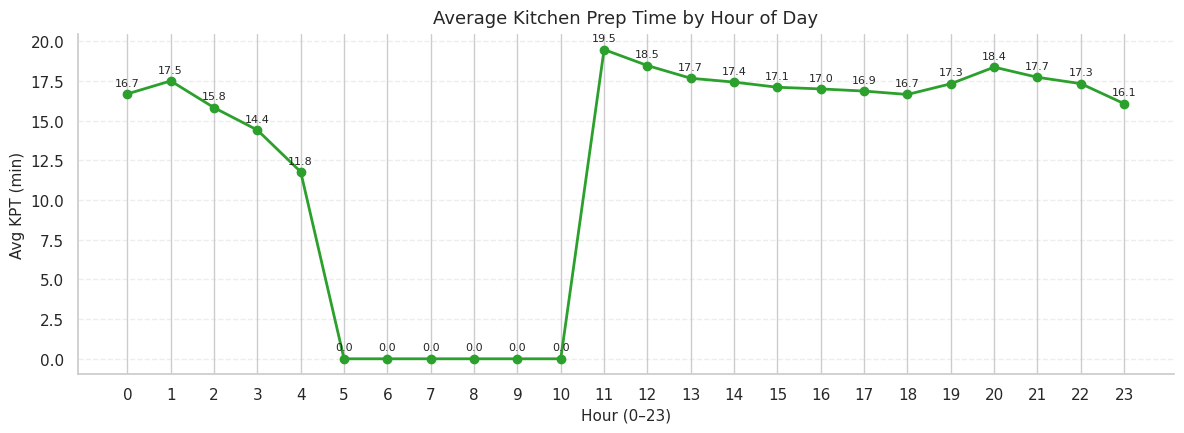

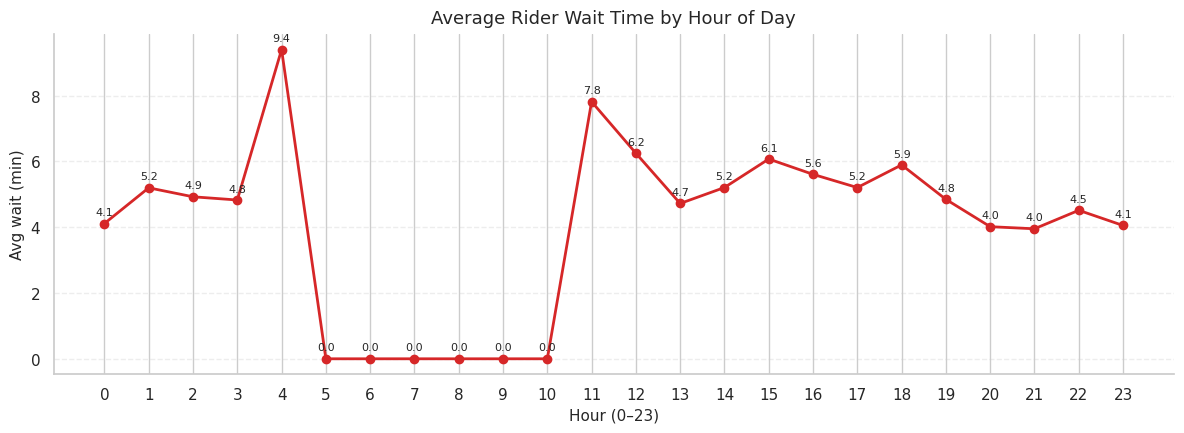

,hour,avg_orders,avg_revenue,avg_kpt,avg_wait
0,0,957.0,₹604335,16.70,4.11
1,1,833.0,₹516746,17.51,5.20
2,2,488.0,₹299161,15.83,4.92
3,3,389.0,₹235511,14.42,4.83
4,4,5.0,₹2471,11.78,9.40
5,5,0.0,₹0,0.00,0.00
6,6,0.0,₹0,0.00,0.00
7,7,0.0,₹0,0.00,0.00
8,8,0.0,₹0,0.00,0.00
9,9,0.0,₹0,0.00,0.00


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, StrMethodFormatter
import pandas as pd

# --- Build hour_summary from your df ---
hour_summary = (
    df.groupby('hour', observed=True)
      .agg(
          avg_orders=('Order ID', 'count'),
          avg_revenue=('Total', 'sum'),
          avg_kpt=('KPT duration (minutes)', 'mean'),
          avg_wait=('Rider wait time (minutes)', 'mean')
      )
      .reset_index()
)

# --- Ensure hour_summary covers 0–23 with explicit zeros ---
hour_summary = (
    hour_summary.set_index('hour')
                .reindex(range(24), fill_value=0)
                .reset_index()
)

def annotate_all_points(ax, xs, ys, fmt="{:.0f}", dy=6, fontsize=8):
    for x, y in zip(xs, ys):
        ax.annotate(fmt.format(y), (x, y),
                    textcoords="offset points", xytext=(0, dy),
                    ha="center", fontsize=fontsize)

# ---------- Orders ----------
fig1, ax1 = plt.subplots(figsize=(12, 4.5))
ax1.plot(hour_summary['hour'], hour_summary['avg_orders'],
         marker='o', linewidth=2, markersize=6, color='tab:blue')
annotate_all_points(ax1, hour_summary['hour'], hour_summary['avg_orders'], fmt="{:.0f}")
ax1.set_title('Average Orders by Hour of Day', fontsize=13, pad=8)
ax1.set_xlabel('Hour (0–23)'); ax1.set_ylabel('Avg orders/hour')
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.grid(True, axis='y', linestyle='--', alpha=0.35)
for s in ['top','right']: ax1.spines[s].set_visible(False)
ax1.set_xticks(np.arange(0, 24, 1))
plt.tight_layout(); plt.show()

# ---------- Revenue ----------
fig2, ax2 = plt.subplots(figsize=(12, 4.5))
ax2.plot(hour_summary['hour'], hour_summary['avg_revenue'],
         marker='o', linewidth=2, markersize=6, color='tab:orange')
annotate_all_points(ax2, hour_summary['hour'], hour_summary['avg_revenue'], fmt="₹{:.0f}")
ax2.set_title('Average Revenue by Hour of Day', fontsize=13, pad=8)
ax2.set_xlabel('Hour (0–23)'); ax2.set_ylabel('Avg revenue/hour (₹)')
ax2.yaxis.set_major_formatter(StrMethodFormatter('₹{x:,.0f}'))
ax2.grid(True, axis='y', linestyle='--', alpha=0.35)
for s in ['top','right']: ax2.spines[s].set_visible(False)
ax2.set_xticks(np.arange(0, 24, 1))
plt.tight_layout(); plt.show()

# ---------- KPT ----------
fig3, ax3 = plt.subplots(figsize=(12, 4.5))
ax3.plot(hour_summary['hour'], hour_summary['avg_kpt'],
         marker='o', linewidth=2, markersize=6, color='tab:green')
annotate_all_points(ax3, hour_summary['hour'], hour_summary['avg_kpt'], fmt="{:.1f}")
ax3.set_title('Average Kitchen Prep Time by Hour of Day', fontsize=13, pad=8)
ax3.set_xlabel('Hour (0–23)'); ax3.set_ylabel('Avg KPT (min)')
ax3.grid(True, axis='y', linestyle='--', alpha=0.35)
for s in ['top','right']: ax3.spines[s].set_visible(False)
ax3.set_xticks(np.arange(0, 24, 1))
plt.tight_layout(); plt.show()

# ---------- Rider Wait ----------
fig4, ax4 = plt.subplots(figsize=(12, 4.5))
ax4.plot(hour_summary['hour'], hour_summary['avg_wait'],
         marker='o', linewidth=2, markersize=6, color='tab:red')
annotate_all_points(ax4, hour_summary['hour'], hour_summary['avg_wait'], fmt="{:.1f}")
ax4.set_title('Average Rider Wait Time by Hour of Day', fontsize=13, pad=8)
ax4.set_xlabel('Hour (0–23)'); ax4.set_ylabel('Avg wait (min)')
ax4.grid(True, axis='y', linestyle='--', alpha=0.35)
for s in ['top','right']: ax4.spines[s].set_visible(False)
ax4.set_xticks(np.arange(0, 24, 1))
plt.tight_layout(); plt.show()

# ---------- Summary Table ----------
display(
    hour_summary.style.format({
        "avg_orders": "{:.1f}",
        "avg_revenue": "₹{:.0f}",
        "avg_kpt": "{:.2f}",
        "avg_wait": "{:.2f}"
    }).set_caption("Average Metrics by Hour of Day")
)


##  Hour-of-Day Performance — Insights

**Demand & Revenue Cycle**
- **Near-zero activity 05:00–10:59**, likely closed/irrelevant for staffing.
- **Dinner dominates**: steep ramp from 18:00 with a **peak at 20:00** (highest orders and ₹/hour).
- Lunch (11:00–14:00) is a **secondary** window.

**Kitchen Prep Time (KPT)**
- Peaks around **11:00** (~19 min), then holds steady **16–18 min** through the afternoon/evening.
- No evidence of breakdown during dinner surge.

**Rider Wait Time**
- Higher at **very low-volume hours** (e.g., ~04:00, ~11:00) — typical of sparse courier supply vs. sporadic orders.
- **Low during the evening peak**, indicating efficient rider allocation under load.

### What we’ll do (business lens)
- **Scheduling:** Maintain strong coverage **18:00–21:00**; no need to expand beyond current levels given low rider waits.
- **Late-Morning Ops:** Watch **11:00** KPT; consider light pre-prep/mise-en-place to smooth lunch queues.
- **Revenue Lift:** Target **lunch promotions (11–14h)** and **Monday** offers to raise off-peak demand.
- **Early Morning:** Avoid adding capacity 05:00–10:59 — demand is effectively zero.


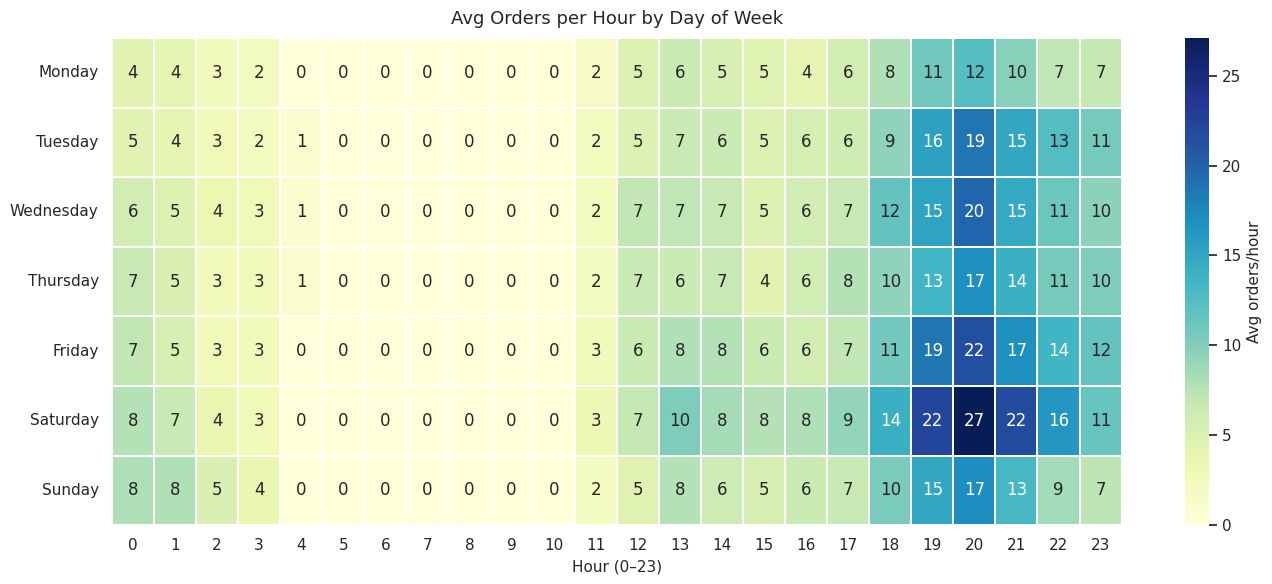

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute average orders per hour per day (so days with more records don’t dominate)
per_day_hour = (
    df.groupby(['date','hour'])
      .agg(orders=('Order ID','count'),
           revenue=('Total','sum'),
           avg_kpt=('KPT duration (minutes)','mean'),
           avg_wait=('Rider wait time (minutes)','mean'))
      .reset_index()
)

# --- Ensure every combination of day_of_week × hour exists ---
all_combos = pd.MultiIndex.from_product(
    [dow_order, range(24)], names=['day_of_week','hour']
)

dow_hour_full = (
    per_day_hour.merge(df[['date','day_of_week']].drop_duplicates(), on='date', how='left')
                .groupby(['day_of_week','hour'], observed=True)
                .agg(avg_orders=('orders','mean'))
                .reindex(all_combos, fill_value=0)       # <-- ensures all 0–23 hours are present
                .reset_index()
)

heat = dow_hour_full.pivot(index='day_of_week', columns='hour', values='avg_orders').loc[dow_order]

plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    heat,
    cmap='YlGnBu',
    annot=True, fmt=".0f",     # label each cell
    cbar_kws={'label':'Avg orders/hour'},
    linewidths=0.3, linecolor='white'
)
plt.title('Avg Orders per Hour by Day of Week', fontsize=13, pad=10)
plt.xlabel('Hour (0–23)')
plt.ylabel('')
plt.tight_layout()
plt.show()


##  Hourly Demand by Day-of-Week (Heatmap)

**Observations**
- **Closed hours:** 05:00–10:59 show *zero* orders across all days → likely non-operational window.
- **Evening dominance:** The **19:00–21:00** band is consistently the strongest; **Saturday 20:00 peaks at ~27 orders/hour** (highest slot of the week).
- **Weekend lift:** Friday and Saturday evenings are visibly darker (higher volume) than Tue–Thu.
- **Lunch bump:** A moderate, repeatable lift around **12:00–14:00** each day—smaller than dinner.

**Implications**
- **Staffing alignment:** Concentrate kitchen lines and rider coverage in **17:00–22:00**, with the most attention on **Fri–Sat evenings**.
- **Lunch coverage:** Keep lean but reliable coverage for **11:00–14:00**; consider targeted lunch promos to grow this window.


,Restaurant name,total_orders,total_revenue,avg_kpt,avg_wait,Restaurant label
0,Aura Pizzas,"14,548","₹10,751,617",17.08,4.94,Aura Pizzas
1,Swaad,"6,332","₹3,545,522",17.77,4.51,Swaad
2,Dilli Burger Adda,227,"₹101,710",19.41,5.09,Dilli Burger Adda
3,Tandoori Junction,154,"₹133,666",21.26,6.18,Tandoori Junction
4,The Chicken Junction,32,"₹12,381",15.55,7.26,The Chicken Junct…
5,Masala Junction,28,"₹9,162",13.66,4.57,Masala Junction


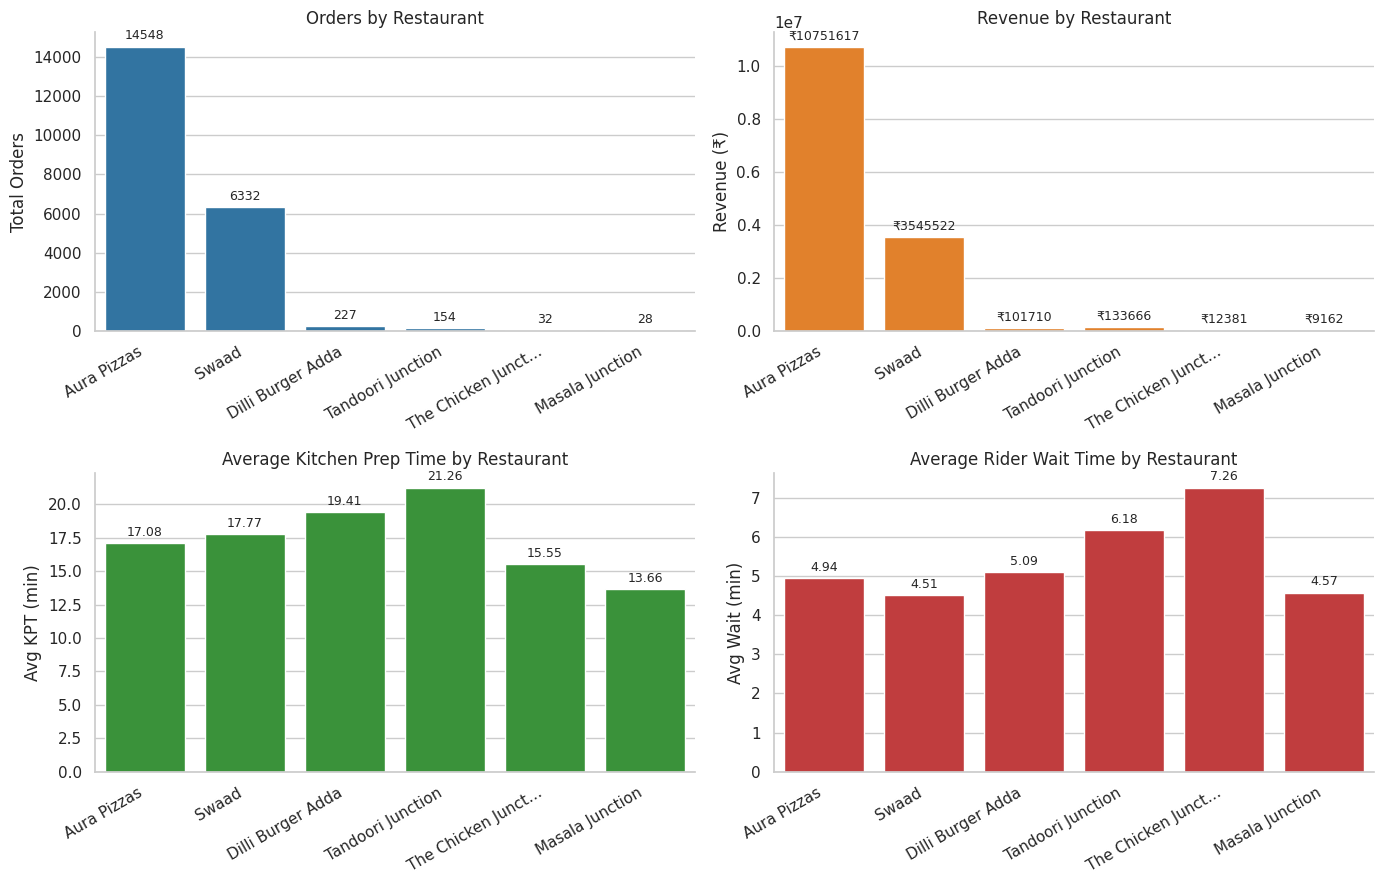

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

sns.set_theme(style="whitegrid", context="notebook")

# ---------- Helpers ----------
def shorten_text(s: str, max_len: int = 18) -> str:
    if pd.isna(s):
        return s
    s = str(s)
    return s if len(s) <= max_len else s[:max_len-1] + "…"

def labeled_bar(ax, data, x, y, color, title, ylab, fmt="%.0f", xtick_rot=30):
    sns.barplot(data=data, x=x, y=y, color=color, ax=ax)
    ax.set_title(title)
    ax.set_ylabel(ylab)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=xtick_rot, ha="right")
    for c in ax.containers:
        ax.bar_label(c, fmt=fmt, padding=3, fontsize=9)
    for s in ("top","right"): ax.spines[s].set_visible(False)

# ===========================
# 1) Demand by Restaurant
# ===========================
restaurant_summary = (
    df.groupby('Restaurant name', as_index=False)
      .agg(total_orders=('Order ID', 'count'),
           total_revenue=('Total', 'sum'),
           avg_kpt=('KPT duration (minutes)', 'mean'),
           avg_wait=('Rider wait time (minutes)', 'mean'))
      .sort_values('total_orders', ascending=False)
      .reset_index(drop=True)
)

# Short labels for plots (keep full names in table)
restaurant_summary['Restaurant label'] = restaurant_summary['Restaurant name'].apply(shorten_text)

# Table (full names)
display(
    restaurant_summary.style.format({
        "total_orders": "{:,.0f}",
        "total_revenue": "₹{:,.0f}",
        "avg_kpt": "{:.2f}",
        "avg_wait": "{:.2f}"
    }).set_caption("📋 Demand by Restaurant")
)

# 2×2 grid of charts (all restaurants)
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
labeled_bar(axes[0,0], restaurant_summary, 'Restaurant label', 'total_orders',
            'tab:blue', "Orders by Restaurant", "Total Orders", "%.0f")
labeled_bar(axes[0,1], restaurant_summary, 'Restaurant label', 'total_revenue',
            'tab:orange', "Revenue by Restaurant", "Revenue (₹)", "₹%.0f")
labeled_bar(axes[1,0], restaurant_summary, 'Restaurant label', 'avg_kpt',
            'tab:green', "Average Kitchen Prep Time by Restaurant", "Avg KPT (min)", "%.2f")
labeled_bar(axes[1,1], restaurant_summary, 'Restaurant label', 'avg_wait',
            'tab:red', "Average Rider Wait Time by Restaurant", "Avg Wait (min)", "%.2f")
plt.tight_layout()
plt.show()

# Separator between topics
display(HTML("<hr style='margin:20px 0;border:0;border-top:1px solid #ddd'>"))



## Demand by Restaurant and Subzone

###  Key Insights — Restaurants
- **Aura Pizzas and Swaad dominate demand** — they together account for the overwhelming majority of orders and revenue (over 95% of total demand).
- The **long tail** of restaurants (Dilli Burger Adda, Tandoori Junction, The Chicken Junction, Masala Junction) contribute minimally to overall demand, suggesting they have less impact on capacity planning.
- **Kitchen Prep Time (KPT):**
  - Highest at **Tandoori Junction** (21.26 min), which could be causing slightly longer rider wait times.
  - Lowest at **Masala Junction** (13.66 min), showing quicker fulfillment — though its volume is too small to materially impact overall performance.
- **Rider Wait Time:** The Chicken Junction has the longest waits (7.26 min) despite its low order volume — likely inefficient scheduling or under-utilization of riders there.

**Actionable Note:**  
Focus capacity planning primarily on **Aura Pizzas** and **Swaad**, as improvements here will yield the largest impact. Lower-volume restaurants may not justify operational changes unless rider wait or KPT issues are severe.

---

,Subzone,total_orders,total_revenue,avg_kpt,avg_wait,Subzone label
0,Greater Kailash 2 (GK2),"7,380","₹4,756,247",17.97,3.69,Greater Kailash 2…
1,Sector 4,"6,530","₹4,494,095",16.26,5.68,Sector 4
2,DLF Phase 1,"3,686","₹2,604,430",18.88,5.78,DLF Phase 1
3,Sector 135,"2,442","₹1,759,094",15.75,5.05,Sector 135
4,Vasant Kunj,920,"₹689,696",17.43,3.15,Vasant Kunj
5,Shahdara,360,"₹249,106",18.47,5.57,Shahdara
6,Chittaranjan Park,2,₹950,14.32,9.90,Chittaranjan Park
7,Sikandarpur,1,₹441,15.87,5.50,Sikandarpur


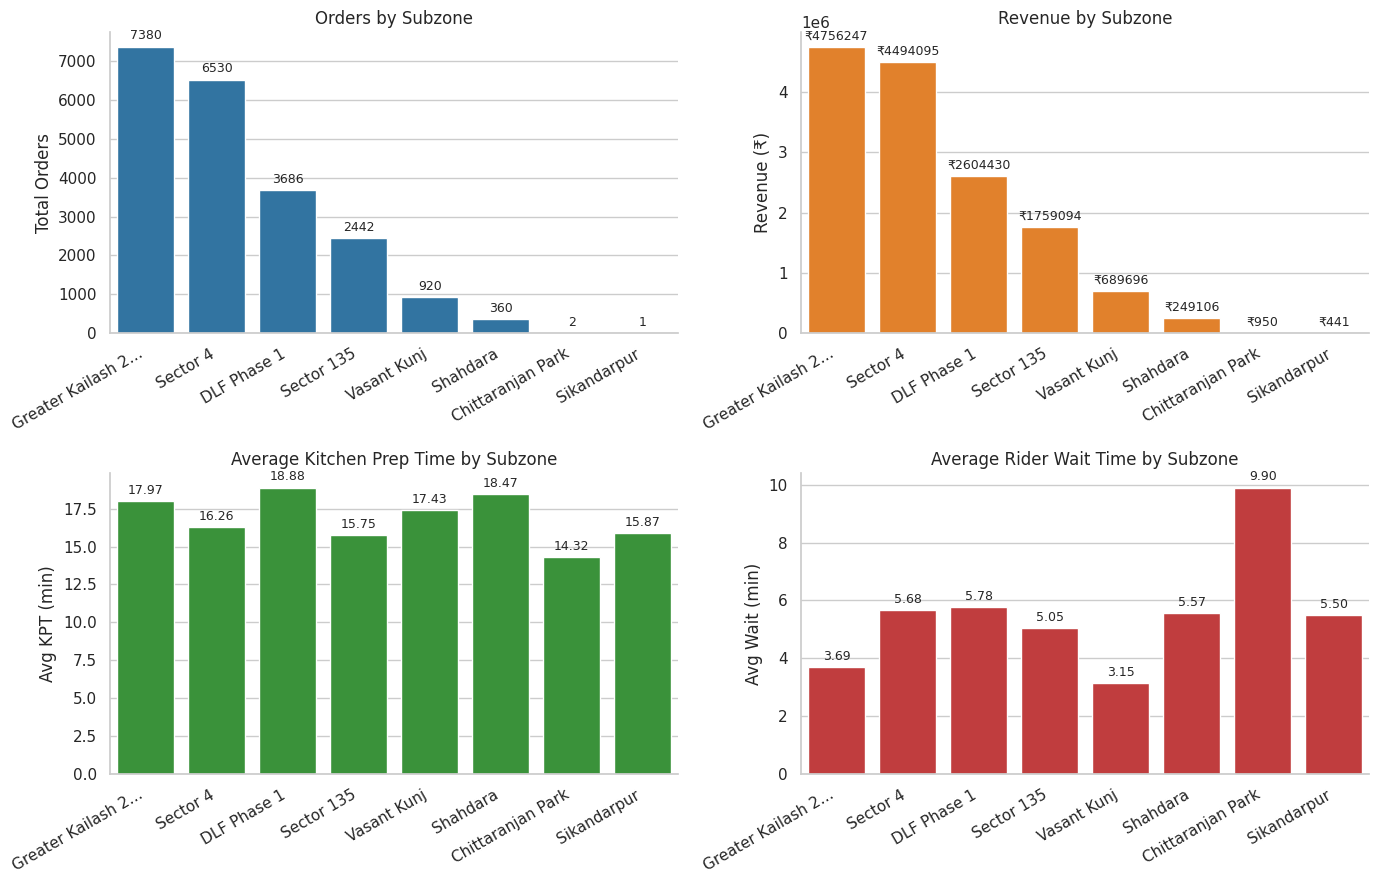

In [28]:
# ===========================
# 2) Demand by Subzone
# ===========================
zone_summary = (
    df.groupby('Subzone', as_index=False)
      .agg(total_orders=('Order ID', 'count'),
           total_revenue=('Total', 'sum'),
           avg_kpt=('KPT duration (minutes)', 'mean'),
           avg_wait=('Rider wait time (minutes)', 'mean'))
      .sort_values('total_orders', ascending=False)
      .reset_index(drop=True)
)

# Short labels for plots (keep full names in table)
zone_summary['Subzone label'] = zone_summary['Subzone'].apply(shorten_text)

# Table (full names)
display(
    zone_summary.style.format({
        "total_orders": "{:,.0f}",
        "total_revenue": "₹{:,.0f}",
        "avg_kpt": "{:.2f}",
        "avg_wait": "{:.2f}"
    }).set_caption("📋 Demand by Subzone")
)

# 2×2 grid of charts (all subzones)
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
labeled_bar(axes[0,0], zone_summary, 'Subzone label', 'total_orders',
            'tab:blue', "Orders by Subzone", "Total Orders", "%.0f")
labeled_bar(axes[0,1], zone_summary, 'Subzone label', 'total_revenue',
            'tab:orange', "Revenue by Subzone", "Revenue (₹)", "₹%.0f")
labeled_bar(axes[1,0], zone_summary, 'Subzone label', 'avg_kpt',
            'tab:green', "Average Kitchen Prep Time by Subzone", "Avg KPT (min)", "%.2f")
labeled_bar(axes[1,1], zone_summary, 'Subzone label', 'avg_wait',
            'tab:red', "Average Rider Wait Time by Subzone", "Avg Wait (min)", "%.2f")
plt.tight_layout()
plt.show()




###  Key Insights — Subzones

- **Volume concentration:** Greater Kailash 2 (GK2) and Sector 4 drive the majority of orders; DLF Phase 1 and Sector 135 form a clear mid-tier.
- **Rider Wait Times (vs network avg ≈ 4.8 min):**
  - **GK2 (3.69 min)** and **Vasant Kunj (3.15 min)** are **below average** — efficient dispatch/hand-off.
  - **Chittaranjan Park (9.9 min)** is based on **2 orders** → not actionable.
- **Kitchen Prep Time:** Highest in **DLF Phase 1 (18.88 min)** and **Shahdara (18.47 min)**; these may be better targets than rider staffing.



####

###

# **Final Conclusions & Recommendations**

This analysis highlights **clear temporal and spatial patterns** in demand:

- **Peak Demand Windows:** Demand follows a **two-peak pattern** — a smaller lunch peak around **12:00–14:00** and a dominant dinner peak between **18:00–22:00**, with orders peaking at 20:00. These are the key periods for kitchen and rider alignment.
- **Day-of-Week Effects:** Friday and Saturday generate the highest order and revenue volumes, yet rider wait times remain close to the overall average (~4–5 min), indicating that current staffing levels appear adequate even under peak load.
- **Operational Metrics:** Kitchen prep time remains stable (16–18 min) throughout the week, with a slight rise on weekends. Rider wait times show no sustained spikes, suggesting no systemic dispatch delays.
- **Geography:** Demand is concentrated in **GK2, Sector 4, DLF Phase 1, and Sector 135**, with GK2 also achieving the fastest rider hand-off times — a potential benchmark for other zones.

### Key Recommendations
- **Prioritize operational tuning** in high-volume zones (Sector 4, DLF Phase 1) — focus on kitchen workflow and dispatch coordination rather than simply adding riders.
- **Maintain current rider staffing** on Fridays and Saturdays — data indicates capacity is well matched to demand during weekend peaks.
- **Investigate kitchen throughput** in DLF Phase 1 and Shahdara, where prep times exceed the overall average.
- **Request rider shift and utilization data** to confirm whether low wait times reflect true efficiency or hidden overstaffing — this will help balance cost efficiency with service quality.
- **Request rider shift and utilization data** to verify whether low wait times are a sign of true efficiency or potential overstaffing, ensuring capacity planning is cost-effective.
